# Setup environment




In [ ]:
import os
from tqdm import tqdm
import cv2
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from google.colab import drive
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import SGD, Adam
from sklearn.utils import shuffle

In [ ]:
drive.mount("/content/gdrive")
os.chdir('gdrive/MyDrive')
if not os.path.exists('CZ4042_project'):
    os.makedirs('CZ4042_project')
os.chdir('CZ4042_project')

Mounted at /content/gdrive


# Data acquisition

Use obtain_fmd_minc_dataset.ipynb to download the FMD and MINC data to drive

# Load FMD data



In [ ]:
x_train_fmd = []
y_train_fmd = []

label_map = {   
                "fabric":0,
                "foliage":1,
                "glass":2,
                "leather":3,
                "metal":4,
                "paper":5,
                "plastic":6,
                "stone":7,
                "water":8,
                "wood":9,
             }

dim = 256
dirs = os.listdir("FMD/image")
for class_dir in dirs:
  class_dir_path = os.path.join("FMD/image/", class_dir)
  num_loaded = 0
  for img_name in os.listdir(class_dir_path):
    if img_name[-3:] != 'jpg':
      continue
    img_path = os.path.join(class_dir_path, img_name)
    img = cv2.imread(img_path)
    targets = np.zeros(10)
    targets[label_map[class_dir]] = 1 
    x_train_fmd.append(cv2.resize(img, (dim, dim)))
    y_train_fmd.append(targets)
    num_loaded += 1
  print("load {}/{} images from {}".format(num_loaded, len(os.listdir(class_dir_path)), class_dir))

y_train_fmd = np.array(y_train_fmd, np.uint8)
x_train_fmd = np.array(x_train_fmd, np.float32)

load 100/101 images from foliage
load 100/100 images from leather
load 100/100 images from glass
load 100/100 images from metal
load 100/100 images from paper
load 100/100 images from plastic
load 100/100 images from water
load 100/100 images from stone
load 100/100 images from wood
load 100/102 images from fabric


# Split FMD data into train, val and test

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42) # StratifiedShuffleSplit ensures a balanced split for all the classes
for train_index, none_train_index in sss.split(x_train_fmd, y_train_fmd):
    print("Using {} for training and {} for validation and test".format(len(train_index), len(none_train_index)))
    x_train_fmd, x_valid_test_fmd = x_train_fmd[train_index], x_train_fmd[none_train_index]
    y_train_fmd, y_valid_test_fmd = y_train_fmd[train_index], y_train_fmd[none_train_index]

Using 700 for training and 300 for validation and test


In [ ]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.33, random_state=42) # StratifiedShuffleSplit ensures a balanced split for all the classes
for val_index, test_index in sss.split(x_valid_test_fmd, y_valid_test_fmd):
    print("Using {} for val and {} for test".format(len(val_index), len(test_index)))
    x_val_fmd, x_test_fmd = x_valid_test_fmd[val_index], x_valid_test_fmd[test_index]
    y_val_fmd, y_test_fmd = y_valid_test_fmd[val_index], y_valid_test_fmd[test_index]

Using 201 for val and 99 for test


# Load MINC dataset



In [ ]:
x_train_minc = []
y_train_minc = []
num_to_load_per_class = 100 # there are 2.5k images per class, we only use 100 here

dirs = os.listdir("MINC/minc-2500/images/")
for class_dir in dirs:
  if class_dir in label_map.keys():
    class_dir_path = os.path.join("MINC/minc-2500/images/", class_dir)
    num_loaded = 0
    for img_name in os.listdir(class_dir_path):
      if img_name[-3:] != 'jpg':
        continue
      img_path = os.path.join(class_dir_path, img_name)
      img = cv2.imread(img_path)
      targets = np.zeros(10)
      targets[label_map[class_dir]] = 1 
      x_train_minc.append(cv2.resize(img, (dim, dim)))
      y_train_minc.append(targets)
      num_loaded += 1
      if num_loaded == num_to_load_per_class:
        break
    print("load {}/{} images from {}".format(num_loaded, len(os.listdir(class_dir_path)), class_dir))

y_train_minc = np.array(y_train_minc, np.uint8)
x_train_minc = np.array(x_train_minc, np.float32)

load 100/2500 images from leather
load 100/2500 images from metal
load 100/2500 images from paper
load 100/2500 images from plastic
load 100/2500 images from stone
load 100/2500 images from water
load 100/2500 images from wood
load 100/2500 images from fabric
load 100/2500 images from foliage
load 100/2500 images from glass


# Split MINC data into train, val and test

In [ ]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42) # StratifiedShuffleSplit ensures a balanced split for all the classes
for train_index, none_train_index in sss.split(x_train_minc, y_train_minc):
    print("Using {} for training and {} for validation and test".format(len(train_index), len(none_train_index)))
    x_train_minc, x_valid_test_minc = x_train_minc[train_index], x_train_minc[none_train_index]
    y_train_minc, y_valid_test_minc = y_train_minc[train_index], y_train_minc[none_train_index]

Using 700 for training and 300 for validation and test


In [ ]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.33, random_state=42) # StratifiedShuffleSplit ensures a balanced split for all the classes
for val_index, test_index in sss.split(x_valid_test_minc, y_valid_test_minc):
    print("Using {} for val and {} for test".format(len(val_index), len(test_index)))
    x_val_minc, x_test_minc = x_valid_test_minc[val_index], x_valid_test_minc[test_index]
    y_val_minc, y_test_minc = y_valid_test_minc[val_index], y_valid_test_minc[test_index]

Using 201 for val and 99 for test


# Merge MINC and FMD train/val data

In [ ]:
# merge train data
x_train = np.concatenate((x_train_fmd, x_train_minc))
y_train = np.concatenate((y_train_fmd, y_train_minc))
x_train, y_train = shuffle(x_train, y_train, random_state=7)
del y_train_minc
del x_train_minc
del y_train_fmd
del x_train_fmd

# merge val data
x_val = np.concatenate((x_val_fmd, x_val_minc))
y_val = np.concatenate((y_val_fmd, y_val_minc))
x_val, y_val = shuffle(x_val, y_val, random_state=7)
del y_val_minc
del x_val_minc
del y_val_fmd
del x_val_fmd

# Data augmentation

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,)
                            #height_shift_range=0.2,
                            #width_shift_range=0.2,
                            #horizontal_flip=True,
                            #rotation_range=30,
                            #brightness_range=[0.7,1.0],
                            #zoom_range=0.3)

val_datagen = ImageDataGenerator(rescale=1./255)

# Load pretrained InceptionV3 (imagenet)

In [ ]:
inc_model = InceptionV3(weights='imagenet',
                        include_top=False,
                        input_shape=(dim, dim, 3))

print("number of layers:", len(inc_model.layers))

# decide whether to freeze pretrained weights
for layer in inc_model.layers:
    layer.trainable = True

87910968/87910968 [==============================] - 3s 0us/step
number of layers: 311


# Append custom Layers

In [ ]:
x = inc_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
predictions = Dense(10, activation="softmax")(x)
model_ = Model(inputs=inc_model.input, outputs=predictions)

# Fine tuning

In [ ]:
epochs = 100
learning_rate = 0.001
batch_size = 32

callbacks = [ EarlyStopping(monitor='val_loss', patience=5, verbose=1), 
              ModelCheckpoint(filepath='weights.best.inc.fmd_minc.hdf5', verbose=1, save_best_only=True),
             #ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
            ]

In [ ]:
# compile the model
model_.compile(optimizer=SGD(lr=learning_rate, momentum=0.9)
                    , loss='categorical_crossentropy'
                    , metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
# ------ TRAINING ------
model_.fit_generator(train_datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=len(x_train)/batch_size, 
                    validation_data=val_datagen.flow(x_val, y_val, batch_size=batch_size), 
                    validation_steps=len(x_val)/batch_size,
                    callbacks=callbacks,
                    epochs=epochs,
                    verbose=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/100
44/43 [==============================] - ETA: 0s - loss: 2.2677 - accuracy: 0.1657
Epoch 1: val_loss improved from inf to 2.01642, saving model to weights.best.inc.fmd_minc.hdf5
43/43 [==============================] - 40s 542ms/step - loss: 2.2677 - accuracy: 0.1657 - val_loss: 2.0164 - val_accuracy: 0.3856
Epoch 2/100
44/43 [==============================] - ETA: 0s - loss: 1.8144 - accuracy: 0.4650
Epoch 2: val_loss improved from 2.01642 to 1.59565, saving model to weights.best.inc.fmd_minc.hdf5
43/43 [==============================] - 17s 393ms/step - loss: 1.8144 - accuracy: 0.4650 - val_loss: 1.5956 - val_accuracy: 0.5174
Epoch 3/100
44/43 [==============================] - ETA: 0s - loss: 1.2944 - accuracy: 0.6443
Epoch 3: val_loss improved from 1.59565 to 1.21479, saving model to weights.best.inc.fmd_minc.hdf5
43/43 [==============================] - 18s 403ms/step - loss: 1.2944 - accuracy: 0.6443 - val_loss: 1.2148 - val_accuracy: 0.6244
Epoch 4/100
44/43 [=======

In [ ]:
import matplotlib.pyplot as plt

def plot_metric(model_, metric, save=False, save_path=None):
    train_metrics = model_.history.history[metric]
    val_metrics = model_.history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    if save:
      plt.savefig(save_path)
    plt.show()

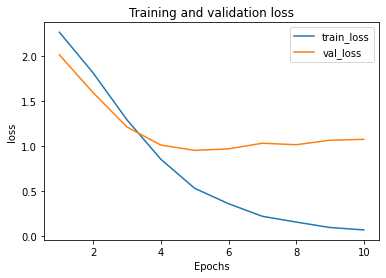

In [ ]:
plot_metric(model_, 'loss')

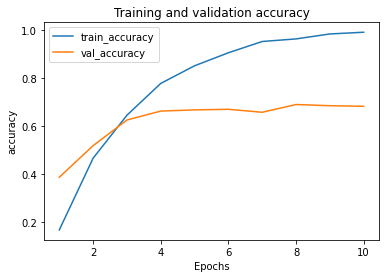

In [ ]:
plot_metric(model_, 'accuracy')

# Evaluation on test data

In [ ]:
# evaluate on fmd test data
model_.evaluate(val_datagen.flow(x_test_fmd, y_test_fmd, batch_size=batch_size))

4/4 [==============================] - 1s 316ms/step - loss: 0.6204 - accuracy: 0.7879


[0.6203511357307434, 0.7878788113594055]

In [ ]:
# evaluate on minc test data
model_.evaluate(val_datagen.flow(x_test_minc, y_test_minc, batch_size=batch_size))

4/4 [==============================] - 0s 71ms/step - loss: 0.9578 - accuracy: 0.6667


[0.9578116536140442, 0.6666666865348816]

In [ ]:
# evaluate on minc + fmd test data
x_test = np.concatenate((x_test_fmd, x_test_minc))
y_test = np.concatenate((y_test_fmd, y_test_minc))

model_.evaluate(val_datagen.flow(x_test, y_test, batch_size=batch_size))

7/7 [==============================] - 1s 213ms/step - loss: 0.7891 - accuracy: 0.7273


[0.7890803813934326, 0.7272727489471436]